# 🦅**Go to NN - with out word embedding**

In [3]:
# Input essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import os, re, csv, math, codecs

sns.set_style("whitegrid")
np.random.seed(50)

MAX_NB_WORDS = 10000


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#load data
train_df = pd.read_csv('/content/drive/MyDrive/New_Approach/train_90.csv', sep=',', header=0)
test_df = pd.read_csv('/content/drive/MyDrive/New_Approach/test_10.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("train set: ", train_df.shape[0])
print("test set: ", test_df.shape[0])

label_names = ["label"]
y_train = train_df[label_names].values
y_test = test_df[label_names].values

train set:  10842
test set:  1205


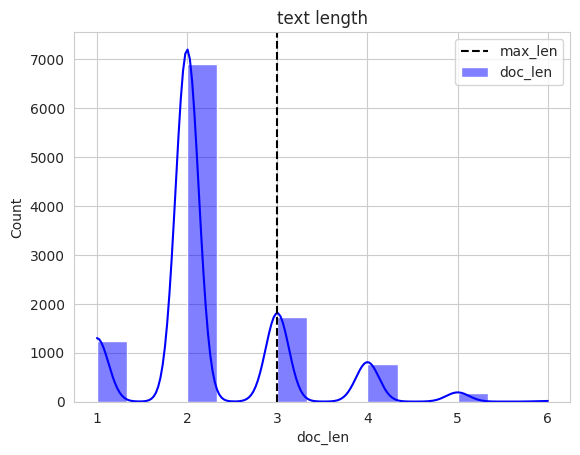

In [6]:
#visualize word distribution
train_df['doc_len'] = train_df['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
#max_seq_len = 5
sns.histplot(train_df['doc_len'],  kde=True, color='b', label='doc_len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max_len')
plt.title('text length'); plt.legend()
plt.show()

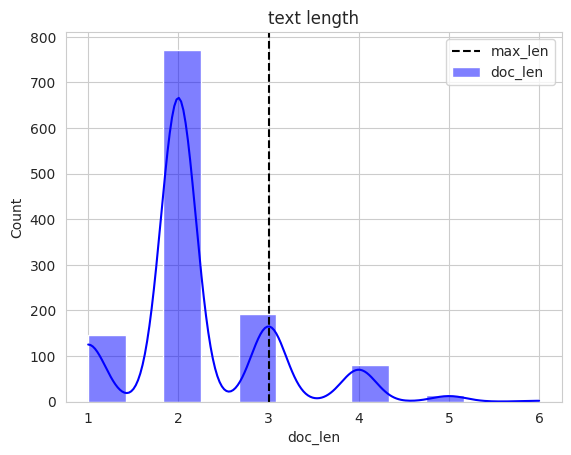

In [7]:
#visualize word distribution
test_df['doc_len'] = test_df['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(test_df['doc_len'].mean() + test_df['doc_len'].std()).astype(int)
#max_seq_len = 5
sns.histplot(test_df['doc_len'], kde=True, color='b', label='doc_len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max_len')
plt.title('text length'); plt.legend()
plt.show()

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = RegexpTokenizer(r'\w+')

raw_docs_train = train_df['text'].tolist()
raw_docs_test = test_df['text'].tolist()
num_classes = len(label_names)

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    #filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(tokens))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    #filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(tokens))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len, padding='post')
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len, padding='post')

100%|██████████| 1205/1205 [00:00<00:00, 396589.48it/s]


tokenizing input data...
dictionary size:  8613


In [9]:
word_seq_train

array([[1555, 1556,    0],
       [1557, 1040,    0],
       [  56,   38,    0],
       ...,
       [ 190, 2077,    0],
       [ 244, 2872,    0],
       [4506, 8209, 1008]], dtype=int32)

In [10]:
#training params
batch_size = 64
num_epochs = 20

#model parameters
num_filters = 64
weight_decay = 1e-4
nb_words = min(MAX_NB_WORDS, len(word_index))
nb_words

8613

## ***ONE-HOT Encoding***

In [11]:
import numpy as np

def one_hot_encode(sequences, vocab_size):
    encoded_sequences = []
    for sequence in sequences:
        encoded_seq = np.zeros((vocab_size, len(sequence))) # Changed shape here
        for i, word_index in enumerate(sequence):
            encoded_seq[word_index, i] = 1 # Changed indexing here
        encoded_sequences.append(encoded_seq)
    return np.array(encoded_sequences)

# One-hot encode your word sequences
word_seq_train_encoded = one_hot_encode(word_seq_train, nb_words)

# Transpose the encoded sequences to match the expected input shape (num_samples, max_seq_len, nb_words)
word_seq_train_encoded = np.transpose(word_seq_train_encoded, (0, 2, 1))

# Verify the shape is now (num_samples, max_seq_len, nb_words)
print(word_seq_train_encoded.shape)


(10842, 3, 8613)


## ✔ **CNN**

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from keras import optimizers, regularizers

# Assuming you have these variables defined:
# nb_words, embed_dim, embedding_matrix, max_seq_len

model_1 = Sequential()
model_1.add(Conv1D(32, 5, activation='relu', input_shape=(max_seq_len, nb_words), padding='same'))
model_1.add(MaxPooling1D(2))
model_1.add(Conv1D(16, 5, activation='relu', padding='same'))  # Reduced filters
model_1.add(GlobalMaxPooling1D())
model_1.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.02)))  # Reduced units, increased L2
model_1.add(Dropout(0.3))  # Increased dropout
model_1.add(Dense(1, activation='sigmoid'))

# Use a smaller learning rate
optimizer = optimizers.Adam(learning_rate=0.0005)
model_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [14]:
import tensorflow as tf

# Force eager execution to help debug
tf.config.run_functions_eagerly(True)

#model training
hist1 = model_1.fit(word_seq_train_encoded, y_train, batch_size=batch_size, epochs=20, validation_split=0.1, verbose=1, callbacks=callbacks_list)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 47s 305ms/step - accuracy: 0.5384 - loss: 0.8485 - val_accuracy: 0.6682 - val_loss: 0.7645
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 81s 301ms/step - accuracy: 0.7425 - loss: 0.7115 - val_accuracy: 0.8240 - val_loss: 0.5888
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 302ms/step - accuracy: 0.9240 - loss: 0.5009 - val_accuracy: 0.9097 - val_loss: 0.4161
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 46s 304ms/step - accuracy: 0.9623 - loss: 0.3239 - val_accuracy: 0.9438 - val_loss: 0.2935
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 304ms/step - accuracy: 0.9757 - loss: 0.2338 - val_accuracy: 0.9613 - val_loss: 0.2368
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 47s 307ms/step - accuracy: 0.9826 - loss: 0.1874 - val_accuracy: 0.9622 - val_loss: 0.2093
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 81s 301ms/step - accuracy: 0.9835 - loss: 0.1712 - val_accuracy: 0.9493 - val_loss: 0.2055
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 46s 302ms/step - accuracy: 0.9896 - loss: 0

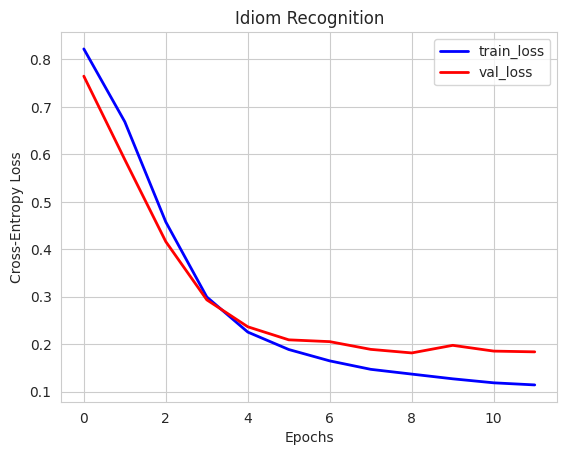

In [15]:
#generate plots
plt.figure()
plt.plot(hist1.history['loss'], lw=2.0, color='b', label='train_loss')
plt.plot(hist1.history['val_loss'], lw=2.0, color='r', label='val_loss')
plt.title('Idiom Recognition')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

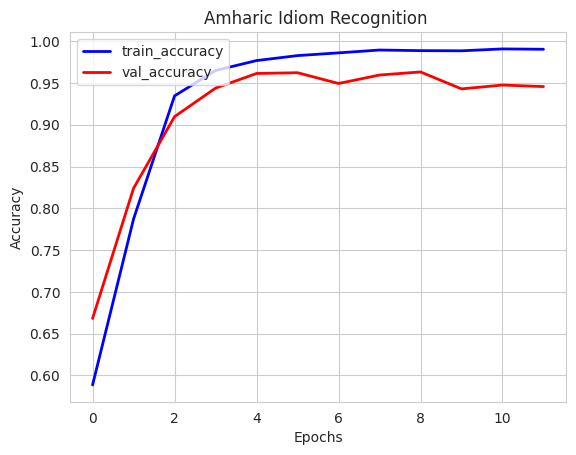

In [16]:
plt.figure()
plt.plot(hist1.history['accuracy'], lw=2.0, color='b', label='train_accuracy')
plt.plot(hist1.history['val_accuracy'], lw=2.0, color='r', label='val_accuracy')
plt.title('Amharic Idiom Recognition ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

## ***Model Evaluation***

In [19]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Ensure all word indices are within the vocabulary bounds
word_seq_test_clipped = np.clip(word_seq_test, 0, nb_words - 1)

# One-hot encode the test data with clipped indices
word_seq_test_encoded = to_categorical(word_seq_test_clipped, num_classes=nb_words)

# Evaluate the model with the encoded data
model_1.evaluate(word_seq_test_encoded, y_test)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9528 - loss: 0.1687


[0.158780038356781, 0.9535269737243652]

In [20]:
y_pred = np.where(model_1.predict(word_seq_test_encoded)>.5,1,0)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [21]:
y_pred = y_pred.ravel()
y_pred

array([0, 1, 0, ..., 1, 0, 1])

In [22]:
y_test = y_test.ravel()
y_test

array([0, 1, 0, ..., 1, 0, 1])

In [23]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       565
           1       0.99      0.92      0.95       640

    accuracy                           0.95      1205
   macro avg       0.95      0.96      0.95      1205
weighted avg       0.96      0.95      0.95      1205



In [24]:
from sklearn import metrics
import tensorflow as tf
y_pred = tf.cast(y_pred, tf.float32)
print("model Loss:",tf.keras.losses.binary_crossentropy(y_test, y_pred))
print("model Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("model Precision:",metrics.precision_score(y_test, y_pred))
print("model Recall:",metrics.recall_score(y_test, y_pred))
print("model F1-score:",metrics.f1_score(y_test, y_pred))

model Loss: tf.Tensor(0.7419117, shape=(), dtype=float32)
model Accuracy: 0.9535269709543569
model Precision: 0.9234375
model Recall: 0.9882943143812709
model F1-score: 0.9547657512116317


## ✔ **LSTM**

In [25]:
model_2 = Sequential()
#model_2.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], trainable=True))
model_2.add(LSTM(64,dropout=0.4,recurrent_dropout=0.4, input_shape=(max_seq_len, nb_words), return_sequences=True)) # Reduced LSTM units, increased dropout
model_2.add(Dropout(0.3))
model_2.add(LSTM(32,dropout=0.3,recurrent_dropout=0.3)) # Reduced LSTM units, increased dropout
model_2.add(Dropout(0.3))
model_2.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.02))) # Reduced Dense units, increased L2 regularization
model_2.add(Dropout(0.4)) # Increased Dropout
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
#model trainingimport tensorflow as tf

# Force eager execution to help debug
tf.config.run_functions_eagerly(True)

#model training
hist2 = model_2.fit(word_seq_train_encoded, y_train, batch_size=batch_size, epochs=20, validation_split=0.1, verbose=1, callbacks=callbacks_list)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 45s 295ms/step - accuracy: 0.5762 - loss: 1.0121 - val_accuracy: 0.8488 - val_loss: 0.5909
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 100s 418ms/step - accuracy: 0.8100 - loss: 0.5357 - val_accuracy: 0.9060 - val_loss: 0.3375
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 61s 278ms/step - accuracy: 0.8640 - loss: 0.3610 - val_accuracy: 0.9023 - val_loss: 0.2733
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 271ms/step - accuracy: 0.8736 - loss: 0.3016 - val_accuracy: 0.8802 - val_loss: 0.2609
Epoch 4: early stopping


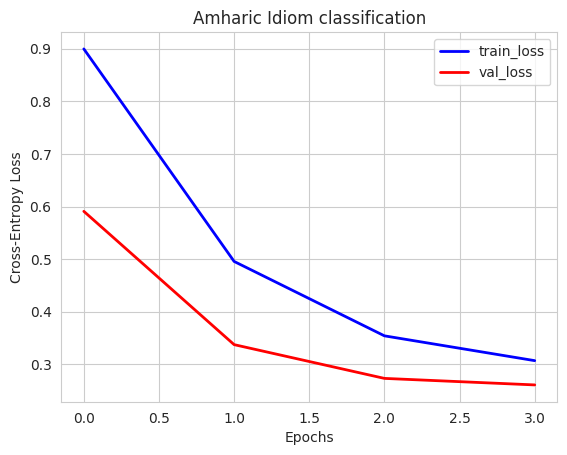

In [27]:
#generate plots
plt.figure()
plt.plot(hist2.history['loss'], lw=2.0, color='b', label='train_loss')
plt.plot(hist2.history['val_loss'], lw=2.0, color='r', label='val_loss')
plt.title('Amharic Idiom classification')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

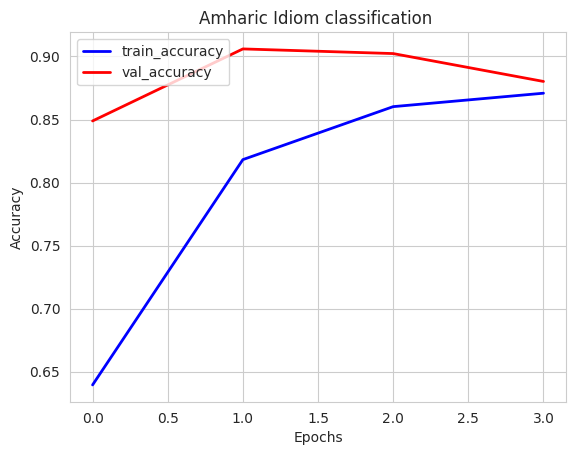

In [28]:
plt.figure()
plt.plot(hist2.history['accuracy'], lw=2.0, color='b', label='train_accuracy')
plt.plot(hist2.history['val_accuracy'], lw=2.0, color='r', label='val_accuracy')
plt.title('Amharic Idiom classification ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

## ✔ **Bi-LSTM**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

model_3 = Sequential()
model_3.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(max_seq_len, nb_words), recurrent_dropout=0.3)))  # Reduced LSTM units, increased recurrent dropout
model_3.add(Dropout(0.4))  # Increased dropout rate
model_3.add(Bidirectional(LSTM(32, recurrent_dropout=0.3)))  # Reduced LSTM units, increased recurrent dropout
model_3.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.02)))  # Increased L2 regularization strength
model_3.add(Dropout(0.3))  # Increased dropout rate
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
#model trainingimport tensorflow as tf

# Force eager execution to help debug
tf.config.run_functions_eagerly(True)

#model training
hist3 = model_3.fit(word_seq_train_encoded, y_train, batch_size=batch_size, epochs=20, validation_split=0.1, verbose=1, callbacks=callbacks_list)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 73s 479ms/step - accuracy: 0.6670 - loss: 1.2039 - val_accuracy: 0.9060 - val_loss: 0.3753
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 480ms/step - accuracy: 0.9610 - loss: 0.2270 - val_accuracy: 0.9189 - val_loss: 0.2348
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 71s 464ms/step - accuracy: 0.9836 - loss: 0.0894 - val_accuracy: 0.9484 - val_loss: 0.1864
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 73s 475ms/step - accuracy: 0.9874 - loss: 0.0573 - val_accuracy: 0.9539 - val_loss: 0.1740
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 74s 483ms/step - accuracy: 0.9882 - loss: 0.0532 - val_accuracy: 0.9576 - val_loss: 0.1670
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 66s 430ms/step - accuracy: 0.9909 - loss: 0.0403 - val_accuracy: 0.9530 - val_loss: 0.1845
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 69s 448ms/step - accuracy: 0.9908 - loss: 0.0394 - val_accuracy: 0.9613 - val_loss: 0.1703
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 79s 430ms/step - accuracy: 0.9907 - loss: 0

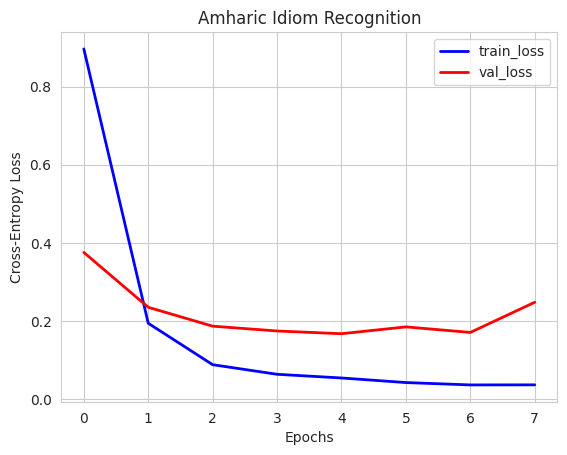

In [31]:
plt.figure()
plt.plot(hist3.history['loss'], lw=2.0, color='b', label='train_loss')
plt.plot(hist3.history['val_loss'], lw=2.0, color='r', label='val_loss')
plt.title('Amharic Idiom Recognition')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

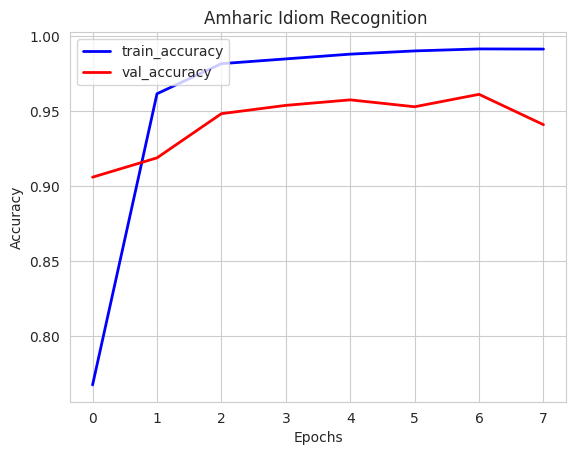

In [32]:
plt.figure()
plt.plot(hist3.history['accuracy'], lw=2.0, color='b', label='train_accuracy')
plt.plot(hist3.history['val_accuracy'], lw=2.0, color='r', label='val_accuracy')
plt.title('Amharic Idiom Recognition ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

## ✔ **GRU**

In [33]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping

model_4 = Sequential()
model_4.add(GRU(32, return_sequences=True, input_shape=(max_seq_len, nb_words), recurrent_dropout=0.4))  # Further reduced units, increased recurrent dropout
model_4.add(Dropout(0.5))  # Increased dropout
model_4.add(GRU(16, recurrent_dropout=0.4))  # Further reduced units, increased recurrent dropout
model_4.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  # Further reduced units, increased L2
model_4.add(Dropout(0.4))  # Increased dropout
model_4.add(Dense(1, activation='sigmoid'))

# Use an even smaller learning rate and early stopping
optimizer = optimizers.Adam(learning_rate=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [34]:
#model training
hist1 = model_4.fit(word_seq_train_encoded, y_train, batch_size=batch_size, epochs=20, validation_split=0.1, verbose=1)#, callbacks=callbacks_list)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 33s 214ms/step - accuracy: 0.5294 - loss: 0.9907 - val_accuracy: 0.6507 - val_loss: 0.9676
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - accuracy: 0.6040 - loss: 0.9595 - val_accuracy: 0.6636 - val_loss: 0.9371
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.6596 - loss: 0.9277 - val_accuracy: 0.7041 - val_loss: 0.9045
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 32s 211ms/step - accuracy: 0.7097 - loss: 0.8912 - val_accuracy: 0.7493 - val_loss: 0.8638
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 33s 214ms/step - accuracy: 0.7713 - loss: 0.8408 - val_accuracy: 0.8230 - val_loss: 0.8030
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.8409 - loss: 0.7607 - val_accuracy: 0.8590 - val_loss: 0.7112
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 34s 221ms/step - accuracy: 0.8747 - loss: 0.6512 - val_accuracy: 0.8876 - val_loss: 0.6042
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 0.9013 - loss: 0

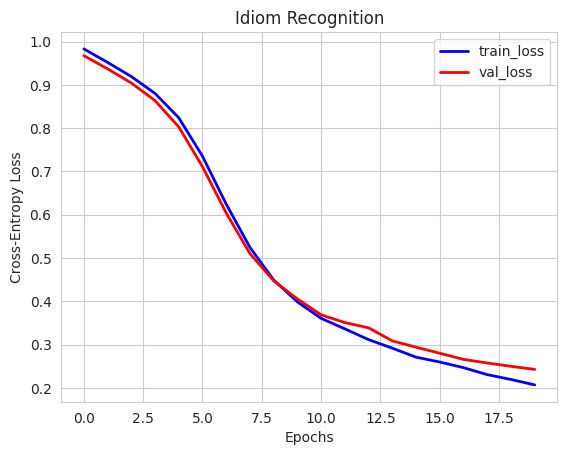

In [35]:
plt.figure()
plt.plot(hist1.history['loss'], lw=2.0, color='b', label='train_loss')
plt.plot(hist1.history['val_loss'], lw=2.0, color='r', label='val_loss')
plt.title('Idiom Recognition')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

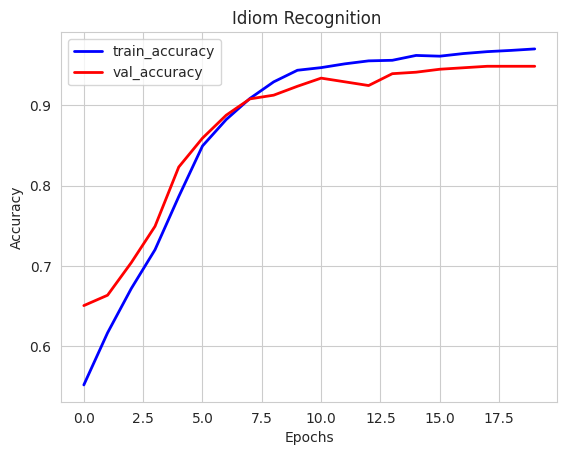

In [36]:
plt.figure()
plt.plot(hist1.history['accuracy'], lw=2.0, color='b', label='train_accuracy')
plt.plot(hist1.history['val_accuracy'], lw=2.0, color='r', label='val_accuracy')
plt.title('Idiom Recognition ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

##📊**Model evaluation and comparison**

In [40]:
# Evaluate CNN
loss_cnn, accuracy_cnn = model_1.evaluate(tf.one_hot(word_seq_test, depth=8613), tf.expand_dims(y_test, axis=-1)) # Convert word_seq_test to one-hot encoded representation
print("CNN - Loss: {}, Accuracy: {}".format(loss_cnn, accuracy_cnn))

# Evaluate LSTM
loss_lstm, accuracy_lstm = model_2.evaluate(tf.one_hot(word_seq_test, depth=8613), tf.expand_dims(y_test, axis=-1)) # Reshape word_seq_test to (number of samples, sequence length, vocabulary size)
print("LSTM - Loss: {}, Accuracy: {}".format(loss_lstm, accuracy_lstm))

# Evaluate Bi-LSTM
loss_bilstm, accuracy_bilstm = model_3.evaluate(tf.one_hot(word_seq_test, depth=8613), tf.expand_dims(y_test, axis=-1)) # Reshape word_seq_test to (number of samples, sequence length, vocabulary size)
print("Bi-LSTM - Loss: {}, Accuracy: {}".format(loss_bilstm, accuracy_bilstm))

# Evaluate GRU
loss_gru, accuracy_gru = model_4.evaluate(tf.one_hot(word_seq_test, depth=8613), tf.expand_dims(y_test, axis=-1)) # Reshape word_seq_test to (number of samples, sequence length, vocabulary size)
print("GRU - Loss: {}, Accuracy: {}".format(loss_gru, accuracy_gru))

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9528 - loss: 0.1687
CNN - Loss: 0.15877960622310638, Accuracy: 0.9535269737243652
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.8888 - loss: 0.2398
LSTM - Loss: 0.2523970603942871, Accuracy: 0.8829875588417053
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9544 - loss: 0.1775
Bi-LSTM - Loss: 0.17353187501430511, Accuracy: 0.954356849193573
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9525 - loss: 0.2198
GRU - Loss: 0.2238762378692627, Accuracy: 0.9485477209091187


In [41]:
results = pd.DataFrame({
    'Model': ['CNN', 'LSTM', 'Bi-LSTM', 'GRU'],
    'Loss': [loss_cnn, loss_lstm, loss_bilstm, loss_gru],
    'Accuracy': [accuracy_cnn, accuracy_lstm, accuracy_bilstm, accuracy_gru]
})

print(results)

     Model      Loss  Accuracy
0      CNN  0.158780  0.953527
1     LSTM  0.252397  0.882988
2  Bi-LSTM  0.173532  0.954357
3      GRU  0.223876  0.948548


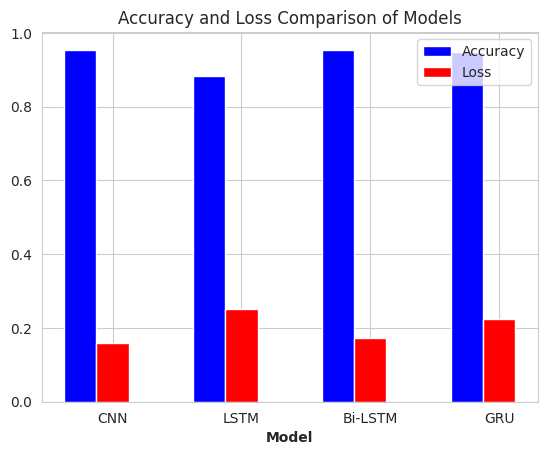

In [42]:
import numpy as np

# Set width of bars
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(results['Accuracy']))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, results['Accuracy'], color='blue', width=barWidth, edgecolor='white', label='Accuracy')
plt.bar(r2, results['Loss'], color='red', width=barWidth, edgecolor='white', label='Loss')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(results['Accuracy']))], results['Model'])

# Create legend & Show graphic
plt.legend()
plt.title('Accuracy and Loss Comparison of Models')
plt.show()